# Semantic Segmentation of Urban Transportation Infrastructure
### MUSA 650: Machine Learning for Remote Sensing

**Elisabeth Ericson**  
in partial collaboration with Benjamin She

In [1]:
import os, cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from datetime import datetime
from glob import glob
from random import sample
from IPython.display import clear_output
from matplotlib import colors
from sklearn.metrics import jaccard_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model

2022-05-19 21:35:48.718222: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Image preprocessing

### Define parameters and functions

In [2]:
# define read-in params

BASEDIR = 'data'

# dataset file structure has each city's images in a separate subdirectory
CITIES = ['koeln']
# CITIES = ['koeln','essen','dortmund','duesseldorf','duisburg']

CLASSES = {
    0:'forest',
    1:'water',
    2:'agricultural',
    3:'urban_fabric',
    4:'grassland',
    5:'railway',
    6:'highway',
    7:'air_ship',
    8:'road',
    9:'building',
    10: 'non-transportation',
    11: 'transportation'}

# mapping to collapse non-transportation classes for five-class schema
classmap_5 = {
    0: 0, 
    1: 0, 
    2: 0, 
    3: 0, 
    4: 0, 
    5: 1, 
    6: 2, 
    7: 3, 
    8: 4, 
    9: 0}

# mapping to assign colormap-compatible values to five-class schema
backmap_5 = {
    0: 10, 
    1: 5,
    2: 6,
    3: 7,
    4: 8}

# mapping to create binary schema (transportation vs. non-transportation)
classmap_2 = {
    0: 0, 
    1: 0, 
    2: 0, 
    3: 0, 
    4: 0, 
    5: 1, 
    6: 1, 
    7: 1, 
    8: 1, 
    9: 0}

# mapping to assign colormap-compatible values to binary schema
backmap_2 = {
    0: 10, 
    1: 11 }

# display labels for plotting by number of classes
display_labels = {
    2: ['non-transportation', 'transportation'],
    5: ['non-transportation', 'railway', 'highway', 'airport/shipyard', 'road'],
    10: ['forest', 'water', 'agricultural', 'urban fabric', 'grassland', 'railway', 'highway', 
         'airport/shipyard', 'road', 'building']
}

In [3]:
# define segmentation mask color map and function to plot it
# adapted from GeoNRW repo: https://github.com/gbaier/geonrw/blob/main/plot_rgb_examples.py

cmap = colors.ListedColormap(
    [
        "#2ca02c",  # green for forest
        "#1f77b4",  # blue for water
        "#8c564b",  # brown for agricultural
        "#7f7f7f",  # gray for urban fabric
        "#bcbd22",  # olive for grassland
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
        "#e377c2",  # pink for buildings
        "#f5f6f7",  # light gray for non-transportation when collapsed
        '#1292a1',  # teal for transportation when collapsed
    ]
)

cmap_norm = colors.Normalize(vmin=0, vmax=11)

In [4]:
# define mapping functions

def remap(mask, map_dict):
    """Recodes mask values according to input dict. Use to create
    reduced-class masks or to map their values back to cmap values.
    """ 
    new_mask = np.zeros_like(mask)
    
    for k, v in map_dict.items():
        new_mask[mask == k] = v
        
    return new_mask

def seg2rgb(seg_map, n_classes):
    """Converts segmentation map to plottable RGB image. """
    map_switch = {
        10: seg_map,
        5: remap(seg_map, backmap_5),
        2: remap(seg_map, backmap_2)}
    seg_map = map_switch[n_classes]
    return cmap(cmap_norm(np.squeeze(seg_map)))[:, :, :3]

In [5]:
# define read-in, display, and preprocessing functions

def read_image(dir):
    """Reads image from directory, resizes to a size divisible by
    32, and normalizes. Returns image as float array.
    """
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (1024, 1024))
    x = x.astype(np.uint8)
    return x

def read_mask(dir):
    """Reads segmentation mask from directory. Resizes to a size
    divisible by 32 using nearest neighbor interpolation to avoid 
    artifacts. Subtracts 1 from class values to start labels at 0, 
    not 1. Returns mask as integer array.
    """
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (1024, 1024), interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.uint8)
    x -= 1
    return x

def show_img_mask(images, masks, i, n_classes):
    """Displays an image and its mask for a given index value."""
    plt.figure(figsize=(18, 8))
    title = ['Input Image', 'True Mask']
    display_list = [images[i], seg2rgb(masks[i], n_classes)]
    for j in range(len(display_list)):
        plt.subplot(1, len(display_list), j+1)
        plt.title(title[j])
        plt.imshow(display_list[j])
        plt.axis('off')
    plt.show()  

In [6]:
# get image and mask file paths, and print lengths

filesImg, filesMsk = [], []

for city in CITIES:
    filesImg.extend(glob(os.path.join(BASEDIR,city,"*.jp2")))
    filesMsk.extend(glob(os.path.join(BASEDIR,city,"*seg.tif")))

filesImg.sort()
filesMsk.sort()

print(f"Images: {len(filesImg)} - Masks: {len(filesMsk)}")

LEN_DATA = len(filesImg)

Images: 479 - Masks: 479


### Read images and masks

In [7]:
images_full, masks_full = [], []

for imgFile in filesImg:
    images_full.append(read_image(imgFile))
for mskFile in filesMsk:
    masks_full.append(read_mask(mskFile))

images_full = np.asarray(images_full)
masks_full = np.asarray(masks_full)

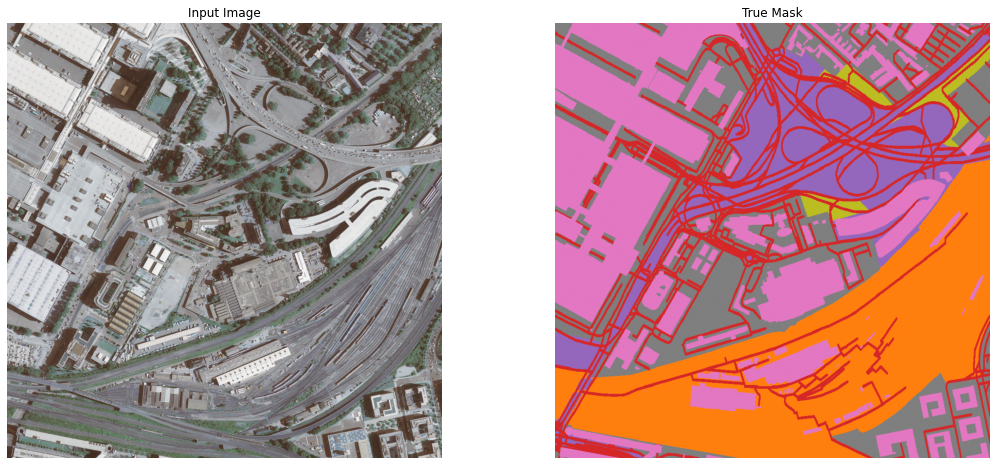

In [8]:
show_img_mask(images_full, masks_full, 266, n_classes=10)

### Split images and masks to create 10-class dataset

In [9]:
# split images and masks in 16 as orthoimagery scale is too big

images, masks = [], []

M = images_full[0].shape[0] // 4
N = images_full[0].shape[1] // 4

for im in images_full:
    images.extend([im[x:x+M, y:y+N] for x in range(0, im.shape[0], M) for y in range(0, im.shape[1], N)])

for mk in masks_full:
    masks.extend([mk[x:x+M, y:y+N] for x in range(0, mk.shape[0], M) for y in range(0, mk.shape[1], N)])

images = np.asarray(images)
masks = np.asarray(masks)

In [10]:
# eliminate first 288 tiles due to segments obscured by heavy rain

images = images[288:].copy()
masks = masks[288:].copy()

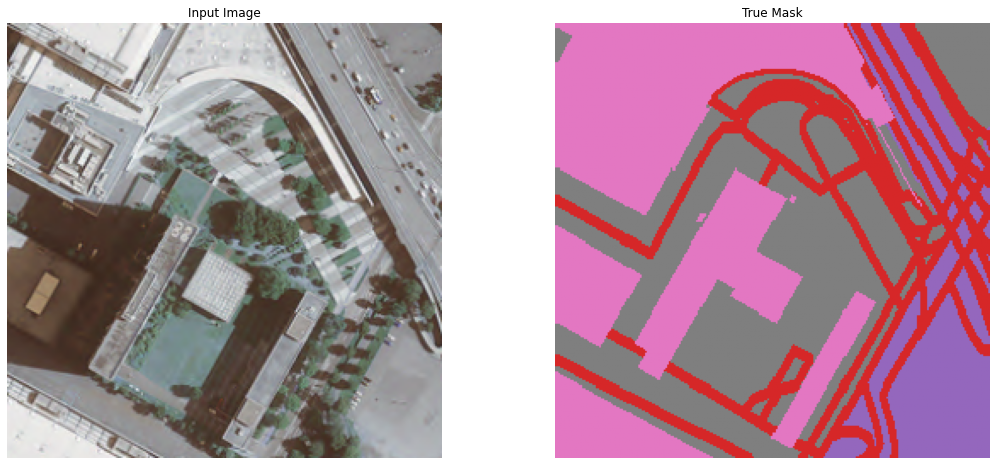

In [11]:
# sample image idx = 4257 in full dataset, 3969 in [288:]

show_img_mask(images, masks, 3969, n_classes=10)

### Collapse non-transportation classes to create five-class masks

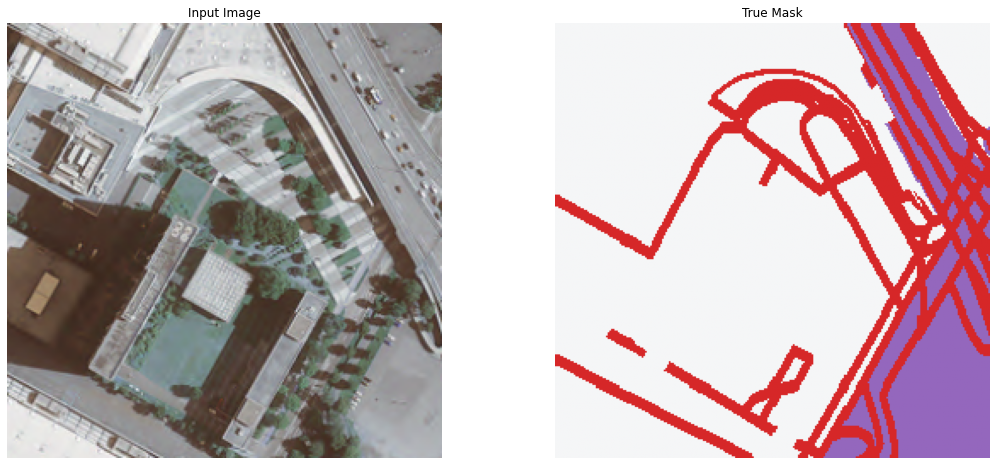

In [12]:
masks_5 = remap(masks, classmap_5)

show_img_mask(images, masks_5, 3969, n_classes=5)

### Collapse transportation and non-transportation classes to create binary masks

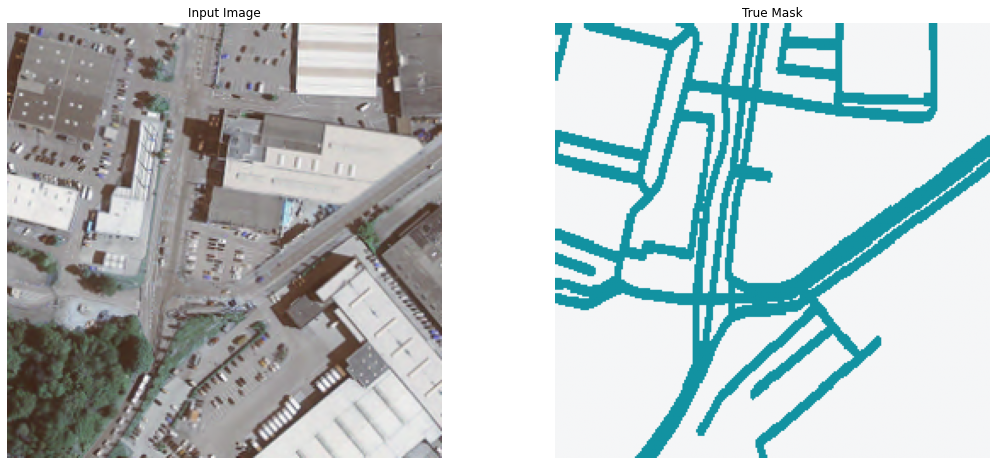

In [13]:
masks_2 = remap(masks, classmap_2)

show_img_mask(images, masks_2, 4257, n_classes=2)

## Data exploration

In [14]:
def getMaskClasses(masklist, numClasses):
    """Returns a dict with the indices of masks sorted by the number of classes
    present in them."""
    # get the classes present on each mask
    classesPresent = np.array([np.unique(mask) for mask in masklist], dtype=object)
    
    # create empty dictionary
    totClassDict = {}

    # classify images by number of classes present in each
    for i in range(1, numClasses+1):
        totalClasses = np.where(np.asarray([array.shape[0] for array in classesPresent]) == i)
        totClassDict[i] = totalClasses[0]
    
    return totClassDict

### All classes

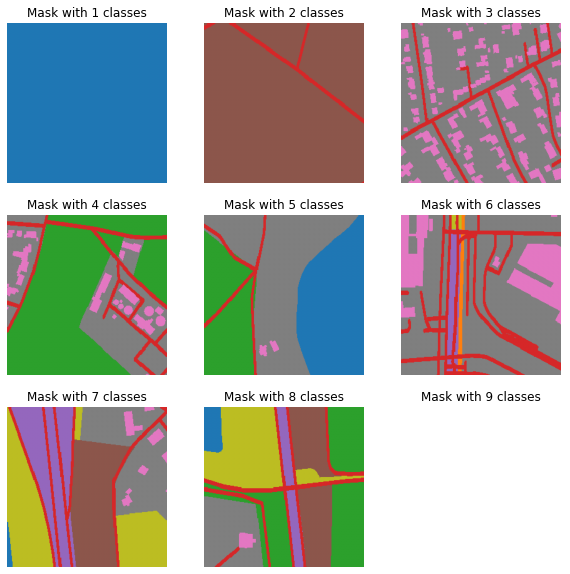

In [15]:
NUM_CLASSES =  10

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES-1):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, n_classes=NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)
        ax.set_xlabel(idx)

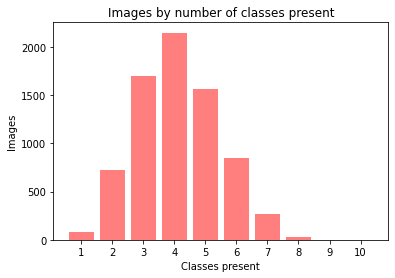

In [16]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1, NUM_CLASSES+1)]

# plot bar
plt.figure(figsize=(6, 4))
plt.bar(range(1, NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes present')
plt.title("Images by number of classes present")
plt.show()

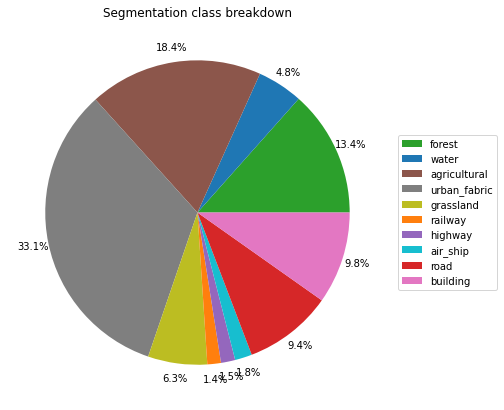

In [17]:
(classNum, counts) = np.unique(masks, return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=cmap.colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

### Reduced classes
Transportation classes distinct, all others collapsed.

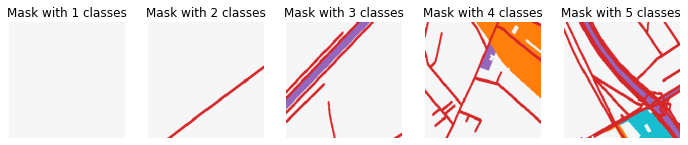

In [18]:
NUM_CLASSES = 5

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_5, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(12, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_5[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_5[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

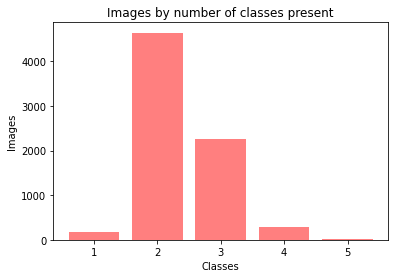

In [19]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(range(1,NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes')
plt.title("Images by number of classes present")
plt.show()

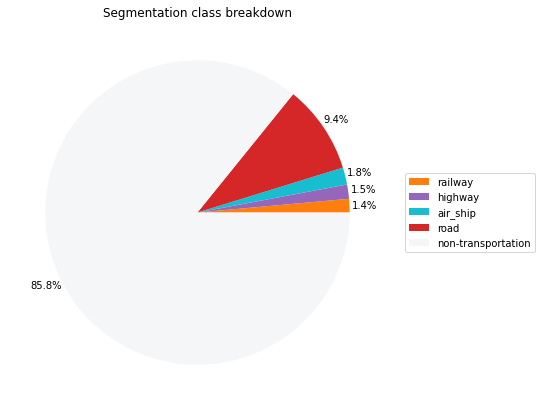

In [20]:
(classNum, counts) = np.unique(remap(masks_5, backmap_5), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors_5 = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors_5, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.show()

### Binary classes

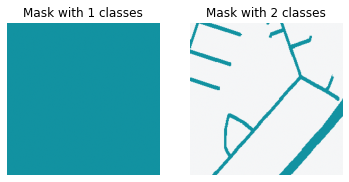

In [21]:
NUM_CLASSES = 2

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_2, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_2[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_2[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

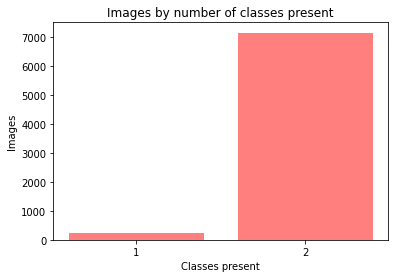

In [22]:
# get total images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(range(1, NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes present')
plt.title("Images by number of classes present")
plt.show()

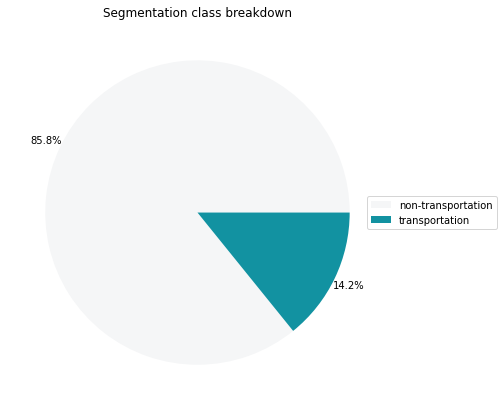

In [23]:
(classNum, counts) = np.unique(remap(masks_2, backmap_2), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

## U-Net models

In [24]:
# define params

SEED = 650
IMG_SIZE = images[0].shape[0]
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 2

In [25]:
# define U-Net building blocks and function
# adapted from https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

def downsample_block(x, n_filters, dropout=0.1):
    f = double_conv_block(x, n_filters, dropout)
    p = MaxPooling2D(2)(f)
    return f, p

def double_conv_block(x, n_filters, dropout):
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Dropout(dropout)(x)
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Dropout(dropout)(x)
    return x

def upsample_block(x, conv_features, n_filters, dropout=0.1):
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(x)
    x = concatenate([x, conv_features])
    x = double_conv_block(x, n_filters, dropout)
    return x

def build_unet():    
    # inputs
    inputs = Input(shape=INPUT_SHAPE)
    
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32, dropout=0.02)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64, dropout=0.02)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128, dropout=0.04)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256, dropout=0.04)
    
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 512, dropout=0.06)
    
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256, dropout=0.04)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128, dropout=0.04)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64, dropout=0.02)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32, dropout=0.02)
    
    # outputs
    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation = "softmax")(u9)
    
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [26]:
# redefine Keras MIoU to work with sparse categorical crossentropy
# drawn from https://stackoverflow.com/a/61826074/6221738

class miou(tf.keras.metrics.MeanIoU):
    def __init__(self,
                 y_true=None,
                 y_pred=None,
                 num_classes=None,
                 name=None,
                 dtype=None):
        super(miou, self).__init__(num_classes=num_classes,name=name, dtype=dtype)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [27]:
def rescale(X_tr, X_te):
    """Rescales image array along RGB channels."""
    
    mean = X_tr.mean((0, 1, 2))
    std = X_tr.std((0, 1, 2))
    
    X_tr_scaled = (X_tr - mean) / std
    X_te_scaled = (X_te - mean) / std
    
    return X_tr_scaled, X_te_scaled, mean, std

def unscale(scaled_image, mean, std):
    """Reverses scaling to plot images in true color."""
    
    image = ((scaled_image * std) + mean).astype('uint8')
    
    return image

In [28]:
# define functions and callback to display sample prediction
# adapted from https://www.tensorflow.org/tutorials/images/segmentation

def display_sample(display_list):
    plt.figure(figsize=(18, 8))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    # if image hasn't been rescaled, it's uint0
    if display_list[0].dtype == 'float64':
        display_list[0] = unscale(display_list[0], mean, std)
    
    for i in range(len(display_list)):
        if i > 0:
            display_list[i] = seg2rgb(display_list[i], NUM_CLASSES)
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    
def display_random_sample(images, masks, predictions=None):
    """Displays a pseudorandom image alongside its mask."""
    
    idx = np.random.randint(0, images.shape[0])
        
    if predictions is None:
        sample_list = [images[idx], masks[idx]]
    else:
        sample_list = [images[idx], masks[idx], predictions[idx]]        
    
    print(idx)
    display_sample(sample_list)
    
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image[tf.newaxis, ...])
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display_sample([sample_image, sample_mask, pred_mask])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [29]:
# define function to plot loss by epoch
# adapted from https://www.tensorflow.org/tutorials/images/segmentation

def plot_loss_history(title):
    """Plots training and validation loss by epoch."""
    
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure()
    plt.plot(model_history.epoch, loss, 'b', label='Training loss')
    plt.plot(model_history.epoch, val_loss, '--r', label='Validation loss')
    plt.suptitle('Training and validation loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

In [30]:
# define a few more functions - these are all mine!
# was pretty happy with the prediction display grid, to be honest

def show_prediction_grid(X, y_true, y_pred, idx_list):
    """Plots a grid of images, masks, and segmentations."""
    
    cols = ['Input Image', 'True Mask', 'Predicted Mask']

    fig, axes = plt.subplots(ncols=3, nrows=len(idx_list), figsize=(9, len(idx_list) * 3))

    for ax, col in zip(axes[0], cols):
        ax.set_title(col)

    for i in range(len(idx_list)):  
        
        idx = idx_list[i]
        img = X[idx] if X[idx].dtype == 'uint8' else unscale(X[idx], mean, std)
        msk = seg2rgb(y_true[idx], NUM_CLASSES)
        pred = seg2rgb(y_pred[idx], NUM_CLASSES)
        
        axes[i, 0].imshow(img)
        axes[i, 1].imshow(msk)
        axes[i, 2].imshow(pred)
        [axi.set_axis_off() for axi in axes.ravel()]

    fig.tight_layout()
    
def print_iou():
    """Prints intersection over union (IoU)/Jaccard score by class."""
    
    jaccard_tr = jaccard_score(y_tr.flatten(), segmentations_tr.flatten(), average=None)
    jaccard_te = jaccard_score(y_te.flatten(), segmentations_te.flatten(), average=None)

    classes = np.unique(np.append(y_tr, y_te)) if y_tr.shape[0] < 1000 else range(NUM_CLASSES)
    classes = np.unique(np.append(y_tr, y_te))
    
    for i in range(len(classes)):
        class_num = classes[i]
        print(f'class {i}: {display_labels[NUM_CLASSES][class_num]}')
        print(f'training IOU: {round(jaccard_tr[i], 3)}')
        print(f'test IOU: {round(jaccard_te[i], 3)}\n')
        
def save_model(model, model_name):
    """Saves model weights to avoid GPU out of memory errors."""
    
    model_dir = 'models'
    now = datetime.now().isoformat(sep='_', timespec='hours')
    
    filename = f'{model_name}_{now}'
    path = os.path.join(model_dir, filename)
    
    model.save_weights(path)

### Binary segmentation

In [276]:
NUM_CLASSES=2

model = build_unet()

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 32) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 9248        dropout_18[0][0]                 
______________________________________________________________________________________________

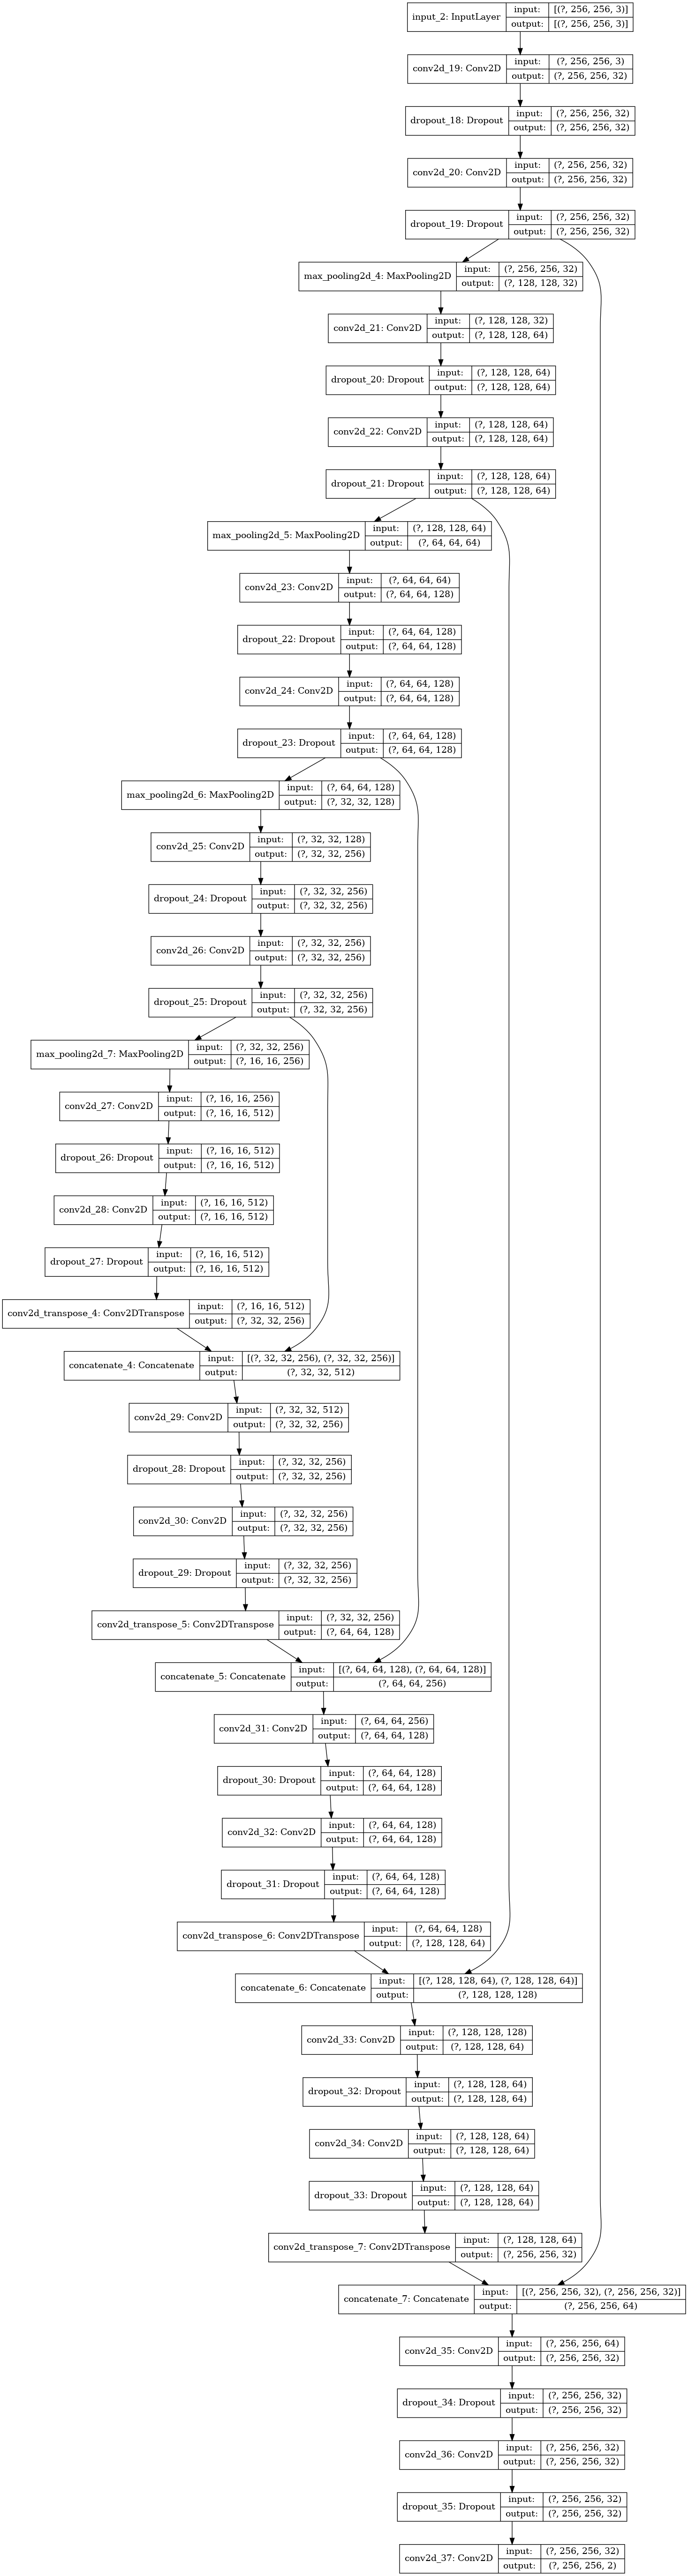

In [277]:
plot_model(model, show_shapes=True, show_layer_names=True)

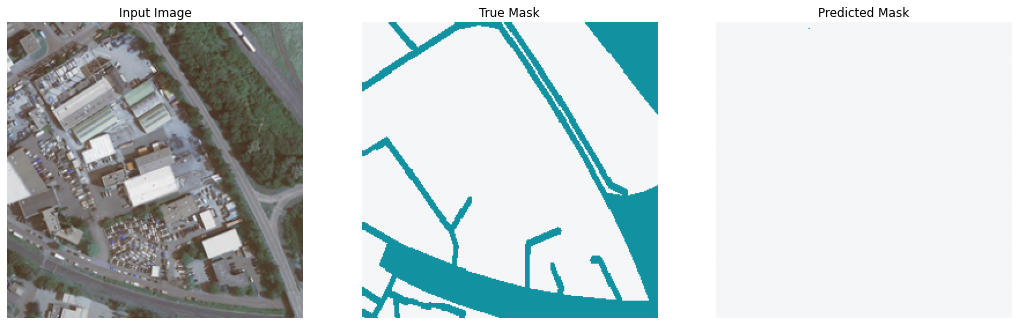


Sample Prediction after epoch 4

422/422 [==============================] - 21s 50ms/step - loss: 0.3514 - miou_1: 0.4331 - accuracy: 0.8663 - val_loss: 0.3772 - val_miou_1: 0.4254 - val_accuracy: 0.8507
Epoch 5/60
131/422 [========>.....................] - ETA: 13s - loss: 0.3502 - miou_1: 0.4323 - accuracy: 0.8606

In [ ]:
NUM_CLASSES = 2

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

# copy instead of slice in hopes of preventing GPU out-of-memory error
n = 7
images_subset = images[::n].copy()
masks_subset = masks[::n].copy()
masks_5_subset = masks_5[::n].copy()
masks_2_subset = masks_2[::n].copy()

# images[::13] = 568 images
# images[::11] = 671 images
# images[::9] = 820 images
# images[::7] = 1,054 images
# images[::5] = 1,476 images
# images[::3] = 2,459 images

X_tr, X_te, y_tr, y_te = train_test_split(
    images_subset,
    masks_2_subset,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED
)

X_tr, X_te, mean, std = rescale(X_tr, X_te)


sample_idx = 165 
# 343 when n = 3

sample_image, sample_mask = (X_tr[sample_idx], y_tr[sample_idx])


NUM_EPOCHS = 60

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=10, verbose=1),
    # reduce learning rate if loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

In [ ]:
save_model(model, 'm2')

X_tr_2, y_tr_2, X_te_2, y_te_2 = X_tr, X_te, y_tr, y_te

#### Loss curve

In [ ]:
plot_loss_history('Two classes, all images')

#### Jaccard score (intersection over union) by class

In [ ]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

print_iou()

#### Sample predictions

In [ ]:
idx_list_tr = sample(range(len(y_tr)), 5)
idx_list_te = sample(range(len(y_te)), 5)

In [ ]:
show_prediction_grid(X_tr, y_tr, segmentations_tr, idx_list_tr)

In [ ]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list_te)

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Plot a sample prediction by channel

In [ ]:
idx = sample_idx

prediction = predictions_te[idx]
segmentation = segmentations_te[idx]

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(3.5, 2.5))
plt.suptitle('Predictions by channel')
[axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
#    ax.set_xticks([])
#    ax.set_yticks([])
    ax.set_title(i)
plt.tight_layout()

In [ ]:
display_sample([X_te[idx], y_te[idx], segmentation])

### Multiclass segmentation: Five classes

In [ ]:
NUM_CLASSES=5

model = build_unet()

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

X_tr, X_te, y_tr, y_te = train_test_split(
    images_subset,
    masks_5_subset,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED
)

X_tr, X_te, mean, std = rescale(X_tr, X_te)

sample_idx = 165 
# 343 when n = 3
sample_image, sample_mask = (X_tr[sample_idx], y_tr[sample_idx])

NUM_EPOCHS = 80

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=10, verbose=1),
    # reduce learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

In [ ]:
save_model(model, 'm5')

X_tr_5, y_tr_5, X_te_5, y_te_5 = X_tr, X_te, y_tr, y_te

#### Loss curve

In [ ]:
plot_loss_history('Five classes, all images')

#### Jaccard score (intersection over union) by class

In [ ]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

print_iou()

#### Sample predictions

In [ ]:
show_prediction_grid(X_tr, y_tr, segmentations_tr, idx_list_tr)

In [ ]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list_te)

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Binary confusion matrix

In [ ]:
# remap test data back to original classes
y_te_5_10 = remap(y_te, backmap_5)
seg_te_5_10 = remap(segmentations_te, backmap_5)

# ...and remap that to binary classes for confusion matrix
y_te_5_2 = remap(y_te_5_10, classmap_2)
seg_te_5_2 = remap(seg_te_5_10, classmap_2)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te_5_2.flatten(), seg_te_5_2.flatten(), 
                                        labels=range(2), display_labels=display_labels[2], 
                                        normalize='true', cmap='pink', ax=ax)

#### Plot predictions by channel

In [ ]:
idx = sample_idx

prediction = predictions_te[idx]
segmentation = segmentations_te[idx]

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(8, 2.25))
plt.suptitle('Predictions by channel')
[axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
plt.tight_layout()

In [ ]:
display_sample([X_te[idx], y_te[idx], segmentation])

### Multiclass segmentation: 10 classes

In [ ]:
NUM_CLASSES=10

model = build_unet()

model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

X_tr, X_te, y_tr, y_te = train_test_split(
    images_subset,
    masks_subset,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED
)

X_tr, X_te, mean, std = rescale(X_tr, X_te)

sample_idx = 165 
# 343 when n = 3

sample_image, sample_mask = (X_tr[sample_idx], y_tr[sample_idx])

NUM_EPOCHS = 100

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=10, verbose=1),
    # reduces learning rate if loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=2, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

In [ ]:
save_model(model, 'm10')

X_tr_10, y_tr_10, X_te_10, y_te_10 = X_tr, X_te, y_tr, y_te

#### Loss curve

In [ ]:
plot_loss_history('All classes, all images')

#### Jaccard score (intersection over union) by class

In [ ]:
predictions_tr = model.predict(X_tr, batch_size=1, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=1, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

In [ ]:
print_iou()

#### Sample predictions

In [ ]:
show_prediction_grid(X_tr, y_tr, segmentations_tr, idx_list_tr)

In [ ]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list_te)

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))

ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Binary confusion matrix

In [ ]:
# remap test data to binary classes for confusion matrix
y_te_10_2 = remap(y_te, classmap_2)
seg_te_10_2 = remap(segmentations_te, classmap_2)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te_10_2.flatten(), seg_te_10_2.flatten(), 
                                        labels=range(2), display_labels=display_labels[2], 
                                        normalize='true', cmap='pink', ax=ax)

#### Five-class confusion matrix

In [ ]:
# remap test data to reduced classes for confusion matrix
y_te_10_5 = remap(y_te, classmap_5)
seg_te_10_5 = remap(segmentations_te, classmap_5)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_te_10_5.flatten(), seg_te_10_5.flatten(), 
                                        labels=range(5), display_labels=display_labels[5], 
                                        normalize='true', cmap='pink', ax=ax)

#### Sample prediction by channel

In [ ]:
idx = sample_idx

prediction = predictions_te[idx]
segmentation = segmentations_te[idx]

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(16, 2.25))
[axi.set_axis_off() for axi in axs.ravel()]
plt.suptitle('Predictions by channel')
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    ax.set_title(i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [ ]:
display_sample([X_te[idx], y_te[idx], segmentation])

In [ ]:
idx = np.random.randint(y_te.shape[0])

prediction = predictions_te[idx]
segmentation = segmentations_te[idx]

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(16, 2.25))
[axi.set_axis_off() for axi in axs.ravel()]
plt.suptitle('Predictions by channel')
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    ax.set_title(i)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [ ]:
print(idx)

In [ ]:
display_sample([X_te[idx], y_te[idx], segmentation])

## Reducing class imbalance

In [ ]:
# get per-image share of pixels in transportation classes
img_size = images[0].size
pct_transportation = [(mask == 1).sum()/img_size for mask in masks_2]

plt.hist(pct_transportation, bins=30, color='red', alpha=0.5)
plt.title('Images by share of transportation pixels')
plt.show()

In [ ]:
# delete images and masks with fewer than 5% of pixels in transportation classes
low_transpo_idx = np.where(np.asarray(pct_transportation) < 0.05)[0]

def delete_low_transpo(array):
    new_array = np.delete(array, low_transpo_idx, axis=0)
    return new_array

In [ ]:
images_b = delete_low_transpo(images)
masks_b = delete_low_transpo(masks)
masks_5b = delete_low_transpo(masks_5)
masks_2b = delete_low_transpo(masks_2)

### All classes

In [ ]:
NUM_CLASSES =  10

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_b, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES-1):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_b[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_b[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, n_classes=NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)
        ax.set_xlabel(idx)
        
(classNum, counts) = np.unique(masks_b, return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=cmap.colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

In [ ]:
NUM_CLASSES = 10

model = build_unet()

model.summary()

In [ ]:
NUM_CLASSES = 10

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

n = 2
images_b_subset = images_b[::n].copy()
masks_b_subset = masks_b[::n].copy()
masks_5b_subset = masks_5b[::n].copy()
masks_2b_subset = masks_2b[::n].copy()

# images_b[::2] = 1,116 images
# images_b[::3] = 744 images

X_tr, X_te, y_tr, y_te = train_test_split(
    images_b_subset,
    masks_b_subset,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED
)

X_tr, X_te, mean, std = rescale(X_tr, X_te)

sample_idx = 161
sample_image, sample_mask = (X_tr[sample_idx], y_tr[sample_idx])

NUM_EPOCHS = 100

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=10, verbose=1),
    # reduces learning rate if loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=2, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

In [ ]:
save_model(model, 'm10b')

X_tr_10b, y_tr_10b, X_te_10b, y_te_10b = X_tr, X_te, y_tr, y_te

#### Loss curve

In [ ]:
plot_loss_history('All classes, >5% transportation images')

#### Jaccard score (intersection over union) by class

In [ ]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

In [ ]:
y_tr.shape

In [ ]:
y_te.shape

In [ ]:
print_iou()

#### Sample predictions

In [ ]:
show_prediction_grid(X_tr, y_tr, segmentations_tr, idx_list_tr)

In [ ]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list_te)

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Five-class confusion matrix

In [ ]:
# remap test data to reduced classes for confusion matrix
y_te_10b_5 = remap(y_te, classmap_5)
seg_te_10b_5 = remap(segmentations_te, classmap_5)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_te_10b_5.flatten(), seg_te_10b_5.flatten(), 
                                        labels=range(5), display_labels=display_labels[5], 
                                        normalize='true', cmap='pink', ax=ax)


#### Binary confusion matrix

In [ ]:
# remap test data to binary classes for confusion matrix
y_te_10b_2 = remap(y_te, classmap_2)
seg_te_10b_2 = remap(segmentations_te, classmap_2)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te_10b_2.flatten(), seg_te_10b_2.flatten(), 
                                        labels=range(2), display_labels=display_labels[2], 
                                        normalize='true', cmap='pink', ax=ax)

### Reduced classes

In [ ]:
NUM_CLASSES = 5

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_5b, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(12, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_5b[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_5b[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

(classNum, counts) = np.unique(remap(masks_5b, backmap_5), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors_5 = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors_5, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.show()

In [ ]:
NUM_CLASSES=5

model = build_unet()

model.summary()

In [ ]:
NUM_CLASSES=5

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

X_tr, X_te, y_tr, y_te = train_test_split(
    images_b_subset,
    masks_5b_subset,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED
)

X_tr, X_te, mean, std = rescale(X_tr, X_te)

sample_idx = 161
sample_image, sample_mask = (X_tr[sample_idx], y_tr[sample_idx])

NUM_EPOCHS = 80

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=10, verbose=1),
    # reduce learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

In [ ]:
save_model(model, 'm5b')

X_tr_5b, y_tr_5b, X_te_5b, y_te_5b = X_tr, X_te, y_tr, y_te

#### Loss curve

In [ ]:
plot_loss_history('Five classes, >5% transportation images')

#### Jaccard score (intersection over union) by class

In [ ]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

In [ ]:
print_iou()

#### Sample predictions

In [ ]:
show_prediction_grid(X_tr, y_tr, segmentations_tr, idx_list_tr)

In [ ]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list_te)

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Binary confusion matrix

In [ ]:
# remap test data back to original classes
y_te_5b_10 = remap(y_te, backmap_5)
seg_te_5b_10 = remap(segmentations_te, backmap_5)

# ...and remap that to binary classes for confusion matrix
y_te_5b_2 = remap(y_te_5_10, classmap_2)
seg_te_5b_2 = remap(seg_te_5_10, classmap_2)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te_5b_2.flatten(), seg_te_5b_2.flatten(), 
                                        labels=range(2), display_labels=display_labels[2], 
                                        normalize='true', cmap='pink', ax=ax)

### Binary classes

In [ ]:
NUM_CLASSES = 2

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_2b, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_2b[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_2b[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)
plt.show()        

(classNum, counts) = np.unique(remap(masks_2b, backmap_2), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

In [ ]:
NUM_CLASSES=2

model = build_unet()

model.summary()

In [ ]:
NUM_CLASSES = 2

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

X_tr, X_te, y_tr, y_te = train_test_split(
    images_b_subset,
    masks_2b_subset,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED
)

X_tr, X_te, mean, std = rescale(X_tr, X_te)

sample_idx = 161
sample_image, sample_mask = (X_tr[sample_idx], y_tr[sample_idx])

NUM_EPOCHS = 60

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=10, verbose=1),
    # reduce learning rate if loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

In [ ]:
save_model(model, 'm2b')

X_tr_2b, y_tr_2b, X_te_2b, y_te_2b = X_tr, X_te, y_tr, y_te

#### Loss curve

In [ ]:
plot_loss_history('Two classes, >5% transportation images')

#### Jaccard score (intersection over union) by class

In [ ]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

In [ ]:
print_iou()

#### Sample predictions

In [ ]:
show_prediction_grid(X_tr, y_tr, segmentations_tr, idx_list_tr)

In [ ]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list_te)

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)